In [1]:
#Standard inmorts 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy import io
from scipy import stats



#the rest should be ML 

from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# K-Means 
from sklearn.cluster import KMeans


# Pipeline stuff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#K-Prototypes
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

## settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Read Data

In [3]:
#df1 = pd.read_feather('../Data3/D3_EKKO-EKPO_raw.ftr', columns=None, use_threads=True)
df2 = pd.read_feather('../Data/D3_EKKO-EKPO_cleaned.ftr', columns=None, use_threads=True)

### Data inspection

In [4]:
#df1.head(5)

In [5]:
df2.sample(5)

,EBELN,EBELP,AEDAT_x,TXZ01,MATNR,EMATN,MATKL,INFNR,MENGE,MEINS,BPRME,NETPR,NETWR,LMEIN,PRDAT,GEWEI,BANFN,AEDAT_y,ERNAM,LPONR,LIFNR,EKGRP,BEDAT
1126,4500000283,60,2021-02-01,Oats,R06,R06,MANUF,5300000055,168550,KG,KG,1.04,175292.0,KG,2021-02-01,KG,10001173,2021-02-01,F3,60,V01,100,2021-02-01
633,4500000162,10,2021-01-28,Large Box (1kg),P01,P01,MANUF,5300000036,40000,ST,ST,0.28,11200.0,ST,2021-01-28,KG,10000649,2021-01-28,D3,40,V02,200,2021-01-28
298,4500000075,20,2021-01-25,Blueberries,R02,R02,MANUF,5300000031,10000,KG,KG,4.19,41900.0,KG,2021-01-25,KG,10000307,2021-01-25,D3,60,V01,100,2021-01-25
1450,4500000363,30,2021-02-04,Strawberries,R03,R03,MANUF,5300000072,35400,KG,KG,4.92,174168.0,KG,2021-02-04,KG,10001562,2021-02-04,H4,60,V01,100,2021-02-04
411,4500000103,50,2021-01-25,Oats,R06,R06,MANUF,5300000085,25200,KG,KG,0.66,16632.0,KG,2021-01-25,nan,10000428,2021-01-25,I3,50,V01,100,2021-01-25


In [6]:
#print(df1.shape)
print(df2.shape)

(1828, 23)


# Filtering

In [7]:
# no Filtering Needed
#df3 = df2.loc[(df2['HKONT'] == '300000')]
df3 = df2.copy()

In [8]:
df3.head(2)

,EBELN,EBELP,AEDAT_x,TXZ01,MATNR,EMATN,MATKL,INFNR,MENGE,MEINS,BPRME,NETPR,NETWR,LMEIN,PRDAT,GEWEI,BANFN,AEDAT_y,ERNAM,LPONR,LIFNR,EKGRP,BEDAT
0,4500000000,10,2021-01-25,Nuts,R01,R01,MANUF,5300000050,41940,KG,KG,1.82,76330.8,KG,2021-01-25,KG,10000004,2021-01-25,F3,60,V01,100,2021-01-25
1,4500000000,20,2021-01-25,Blueberries,R02,R02,MANUF,5300000051,14280,KG,KG,4.00,57120.0,KG,2021-01-25,KG,10000005,2021-01-25,F3,60,V01,100,2021-01-25


### Del Data before clustering

We won't use some data that is used in PM for the clustering, hence it would drastically change 

an therefore create final dataset used

In [9]:
df = df3.drop(['EBELN', 'EBELP', 'AEDAT_x', 'BEDAT','EMATN', 'BPRME', 'INFNR', 'GEWEI', 'PRDAT', 'AEDAT_y'], axis=1).copy()

In [10]:
cats_cat = list(df.select_dtypes(include=['category']).columns)
nums_cat = list(df.select_dtypes(include=['float64', 'int64']).columns)

In [11]:
df.head(2)

,TXZ01,MATNR,MATKL,MENGE,MEINS,NETPR,NETWR,LMEIN,BANFN,ERNAM,LPONR,LIFNR,EKGRP
0,Nuts,R01,MANUF,41940,KG,1.82,76330.8,KG,10000004,F3,60,V01,100
1,Blueberries,R02,MANUF,14280,KG,4.00,57120.0,KG,10000005,F3,60,V01,100


# 2. Preparing

Approach: 
- analyse data to set number of clusters
    - test 

In [12]:
df_kp = df.copy()

In [13]:
df_kp.dtypes

TXZ01    category
MATNR    category
MATKL    category
MENGE       int64
MEINS    category
NETPR     float64
NETWR     float64
LMEIN    category
BANFN    category
ERNAM    category
LPONR    category
LIFNR    category
EKGRP    category
dtype: object

In [14]:
df_corc = df_kp.copy()

In [15]:
cats_cat = df_corc[cats_cat]
        
for (columnName, columnData) in cats_cat.items():
    df_corc[columnName] = df_corc[columnName].astype(str)
    if isinstance(df_corc[columnName][0], str):
        s = pd.Series(df_corc[columnName], dtype="category")
        df_corc[columnName] = s.cat.rename_categories(np.arange(len(np.unique(df_corc[columnName]))))

# 2. Clustering using K-Prototype


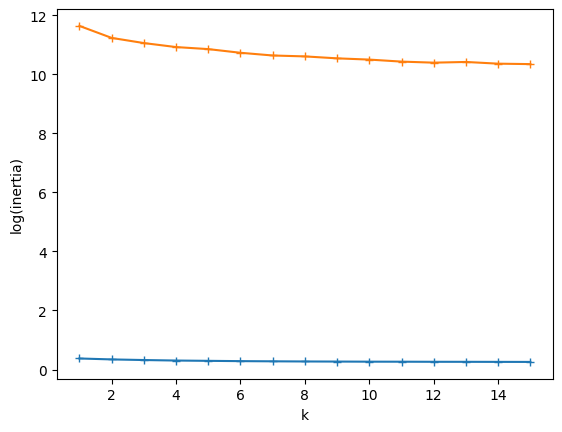

In [16]:
# GAP
import fg_cleansing_helper_new as fg


#create a K-Proto Classifier
catColumnsPos = [df_corc.columns.get_loc(col) for col in list(df_corc.select_dtypes('category').columns)]
kprototype = KPrototypes(n_jobs = -1, init = 'Cao', random_state = 0, max_iter = 100, verbose=False)

#Compute gap with Classifier
k_max = 15
gap, reference_inertia, ondata_inertia = fg.compute_gap_k_proto(kprototype, df_corc.to_numpy(), catColumnsPos, k_max)

# plot results 1
plt.plot(range(1, k_max+1), reference_inertia,
         '-+', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-+', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()

Text(0.5, 0, 'k')

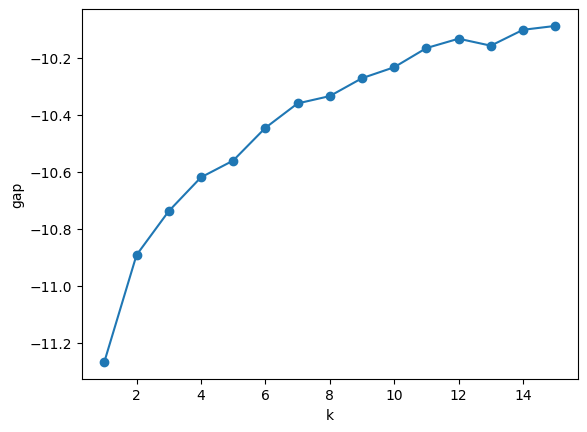

In [18]:
# plot GAP Statistics
plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

## 2.2 Clustering

In [20]:

random_state = 1234
pd.options.plotting.backend = "plotly"
#import timeit

# Convert dataframe to matrix
dfMatrix = df_corc.to_numpy()
# Choose optimal K using Elbow method
l_elbow = []
l_silh = []
l_chi1 = []
l_dbsc = []
print(dfMatrix.shape)
print(df_corc.shape)

#define cat vars for K-prototypes as numerical list
catColumnsPos = [df_corc.columns.get_loc(col) for col in list(df_corc.select_dtypes('category').columns)]
print(catColumnsPos)
print('Categorical columns: {}'.format(list(df_corc.select_dtypes('category').columns)))


for cluster in range(1, 15):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 0, max_iter = 100, verbose=False) #Cao
        #print('step')
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        print('cluster:' + str(cluster))
        l_elbow.append(kprototype.cost_) #inertia_
        

        print('Cluster initiation: {}'.format(cluster))
        #lets calc some scores
        if cluster > 1:
            l_chi1.append(metrics.calinski_harabasz_score(dfMatrix, kprototype.labels_))
            l_silh.append(metrics.silhouette_score(dfMatrix, kprototype.labels_, metric='euclidean'))
            l_dbsc.append(metrics.davies_bouldin_score(dfMatrix, kprototype.labels_))
        #test
        else:
            l_dbsc.append(0)
            l_chi1.append(0)
            l_silh.append(0)

    except:
        break
    

print('finished Kproto')

(1828, 13)
(1828, 13)
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12]
Categorical columns: ['TXZ01', 'MATNR', 'MATKL', 'MEINS', 'LMEIN', 'BANFN', 'ERNAM', 'LPONR', 'LIFNR', 'EKGRP']
cluster:1
Cluster initiation: 1
cluster:2
Cluster initiation: 2
cluster:3
Cluster initiation: 3
cluster:4
Cluster initiation: 4
cluster:5
Cluster initiation: 5
cluster:6
Cluster initiation: 6
cluster:7
Cluster initiation: 7
cluster:8
Cluster initiation: 8
cluster:9
Cluster initiation: 9
cluster:10
Cluster initiation: 10
cluster:11
Cluster initiation: 11
cluster:12
Cluster initiation: 12
cluster:13
Cluster initiation: 13
cluster:14
Cluster initiation: 14
finished Kproto


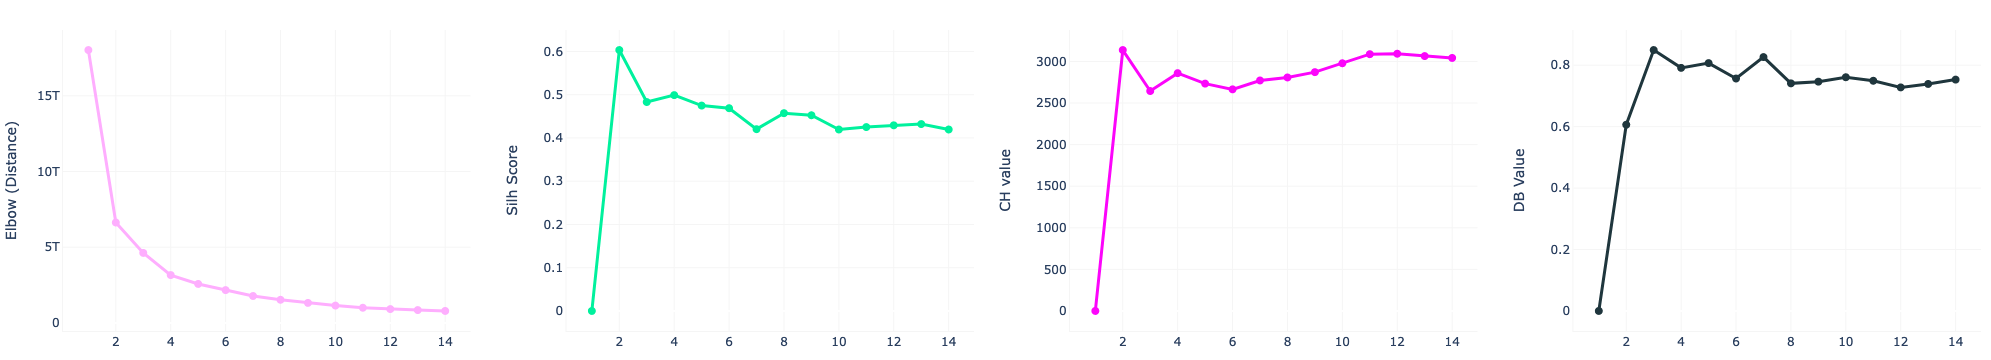

In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

mypal2 =['#FEAEFE', '#FC05FB', '#B4FFE4', '#3FFEBA', '#1F363D', '#2B4570', '#3A2D32', '#706F6F']

a = len(l_dbsc) + 1

df_chi = pd.DataFrame({'Cluster':range(1, a), 'CH value':l_chi1})
df_silh = pd.DataFrame({'Cluster':range(1, a), 'S Score':l_silh})
df_elbow = pd.DataFrame({'Cluster':range(1, a), 'Cost':l_elbow})
df_dbsc = pd.DataFrame({'Cluster':range(1, a), 'DB value':l_dbsc})

fig = make_subplots(rows=1, cols=4) #for titles above -->
subplot_titles=("CH value", "Silhouette index", "Elbow", 'DB value')

trace1 = px.line(df_elbow, x="Cluster", y="Cost")
trace2 = px.line(df_silh, x="Cluster", y="S Score")
trace3 = px.line(df_chi, x="Cluster", y="CH value")
trace4 = px.line(df_dbsc, x="Cluster", y="DB value")

#1
fig.add_trace(go.Scatter(mode='lines+markers', x=trace1.data[0]['x'], y=trace1.data[0]['y'],text=trace1.data[0]['x'], line = dict(color='#FEAEFE', width=3), marker=dict(size=8), legendgroup="Calinski Harabasz Index"), row=1, col=1, ) #, name="Chi"
#fig.update_traces(textposition='top right', line = dict(color='#FEAEFE', width=3), marker=dict(size=8))
fig['layout']['yaxis1']['title']='Elbow (Distance)'
fig['layout']['yaxis2']['title']='Silh Score'
fig['layout']['yaxis3']['title']='CH value'
fig['layout']['yaxis4']['title']='DB Value'


#2
fig.add_trace(go.Scatter(mode='lines+markers', x=trace2.data[0]['x'], y=trace2.data[0]['y'], text=trace2.data[0]['x'], line = dict(color='#00F19D', width=3), marker=dict(size=8), legendgroup="Sillhouette Score"), row=1, col=2) #, name="Silhouette"
#fig.update_traces(textposition='top right')

#3
fig.add_trace(go.Scatter(mode='lines+markers', x=trace3.data[0]['x'], y=trace3.data[0]['y'], text=trace3.data[0]['x'], line = dict(color='#FC05FB', width=3), marker=dict(size=8), legendgroup="Elbow Method"), row=1, col=3) #, name="Elbow"
#fig.update_traces(textposition='top right')

#3
fig.add_trace(go.Scatter(mode='lines+markers', x=trace4.data[0]['x'], y=trace4.data[0]['y'], text=trace4.data[0]['x'], line = dict(color='#1F363D', width=3), marker=dict(size=8), legendgroup="DB value"), row=1, col=4) #, name="Elbow"
#fig.update_traces(textposition='top right')

# customization
fig.update_traces(textposition='top right')
#fig['layout']['xaxis1']['title']='CH value'
#fig['layout']['xaxis2']['title']='Silhouette index'
#fig['layout']['xaxis3']['title']='Elbow'

fig.update_xaxes(nticks=10, linecolor='#F5F5F5', gridcolor='#F5F5F5')
fig.update_yaxes(linecolor='#F5F5F5', gridcolor='#F5F5F5')
fig.update_layout(plot_bgcolor='white')
fig.update_layout(height=290, width=1200)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=20))
#fig.update_layout(title_text="Clustering Metrics for K-Prototypes")
#fig.update_layout(showlegend=False)
fig.update_layout(legend=dict(
    orientation="h",
    xanchor="right",
    yanchor="bottom",
    y=-0.3, 
    x=1 
))
fig.update_layout(showlegend=False)
fig.show()

#export
fig.write_image("EK_Metrics_placeholder.pdf")

### final results Kproto

In [118]:
# number of clusters
K = 2
# no. of points
N = df_corc.shape[0] 
# no. of dimensions
M = df_corc.shape[1]

# no. of numerical dimensions
#MN = 5
# no. of times test is repeated
#T = 3

kp = KPrototypes(n_clusters=K, init='Huang', n_init=1, verbose=False, n_jobs = -1)
kp.fit_predict(dfMatrix, categorical = catColumnsPos)

print(kp.cluster_centroids_)
print(kp.labels_)
print(kp.labels_.shape)

[[2.19183619e+05 2.50271967e-01 5.30461540e+04 2.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 2.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00]
 [3.95344370e+04 2.17388148e+00 5.05779563e+04 9.00000000e+00
  8.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.00000000e+00 2.00000000e+00 4.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[1 1 1 ... 1 1 1]
(1828,)


In [37]:
#add results to original Dataset 
df3['kproto_labels'] = kp.labels_

## Cluster Metrics with Kproto
- elbwo
- silloutte 
- gap statistics
- harabaz index


In [119]:
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances
print(metrics.silhouette_score(dfMatrix, kp.labels_, metric='euclidean'))
print(metrics.calinski_harabasz_score(dfMatrix, kprototype.labels_))
print(metrics.davies_bouldin_score(dfMatrix, kprototype.labels_))
print(np.unique(kp.labels_, return_counts=True))

0.603219762687813
3042.3161637521
0.7530578860267209
(array([0, 1], dtype=uint16), array([ 478, 1350]))


# 3. clustering with DBSCAN

In [38]:
df_gw = df.iloc[:,:].copy()

In [39]:
df.head(2)

,TXZ01,MATNR,MATKL,MENGE,MEINS,NETPR,NETWR,LMEIN,BANFN,ERNAM,LPONR,LIFNR,EKGRP
0,Nuts,R01,MANUF,41940,KG,1.82,76330.8,KG,10000004,F3,60,V01,100
1,Blueberries,R02,MANUF,14280,KG,4.00,57120.0,KG,10000005,F3,60,V01,100


In [40]:
df_gw.head(5)
#df_corc.head(5) alternative

,TXZ01,MATNR,MATKL,MENGE,MEINS,NETPR,NETWR,LMEIN,BANFN,ERNAM,LPONR,LIFNR,EKGRP
0,Nuts,R01,MANUF,41940,KG,1.82,76330.8,KG,10000004,F3,60,V01,100
1,Blueberries,R02,MANUF,14280,KG,4.00,57120.0,KG,10000005,F3,60,V01,100
2,Strawberries,R03,MANUF,14280,KG,4.02,57405.6,KG,10000006,F3,60,V01,100
3,Raisins,R04,MANUF,39900,KG,1.07,42693.0,KG,10000007,F3,60,V01,100
4,Wheat,R05,MANUF,123000,KG,0.99,121770.0,KG,10000008,F3,60,V01,100


In [41]:
import gower

distance_matrix = gower.gower_matrix(np.asarray(df_gw))


In [42]:
df_gw.shape

(1828, 13)

In [43]:
distance_matrix.shape

(1828, 1828)

## initial DBSCAN testwith wide range cluster

In [44]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.26, 
                        min_samples=14, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)



DBSCAN(eps=0.26, metric='precomputed', min_samples=14)

In [45]:
print(metrics.silhouette_score(distance_matrix, dbscan_cluster.labels_, metric='precomputed')) #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, dbscan_cluster.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, dbscan_cluster.labels_)) #lower ist better 
print(np.unique(dbscan_cluster.labels_, return_counts=True))

0.54525983
14956.414465260852
0.3128433029171745
(array([0, 1]), array([1228,  600]))


In [33]:
# Adding the last results to a new column in the dataframe
#df3["dbscan_gower"] = dbscan_cluster.labels_

## DBSCAN with calculated Eps
- min samples should be arround No. of features
- Eps can be calculated

In [56]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=100, metric='precomputed')
neighbors_fit = neighbors.fit(distance_matrix)
distances, indices = neighbors_fit.kneighbors(distance_matrix)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.plot(distances)

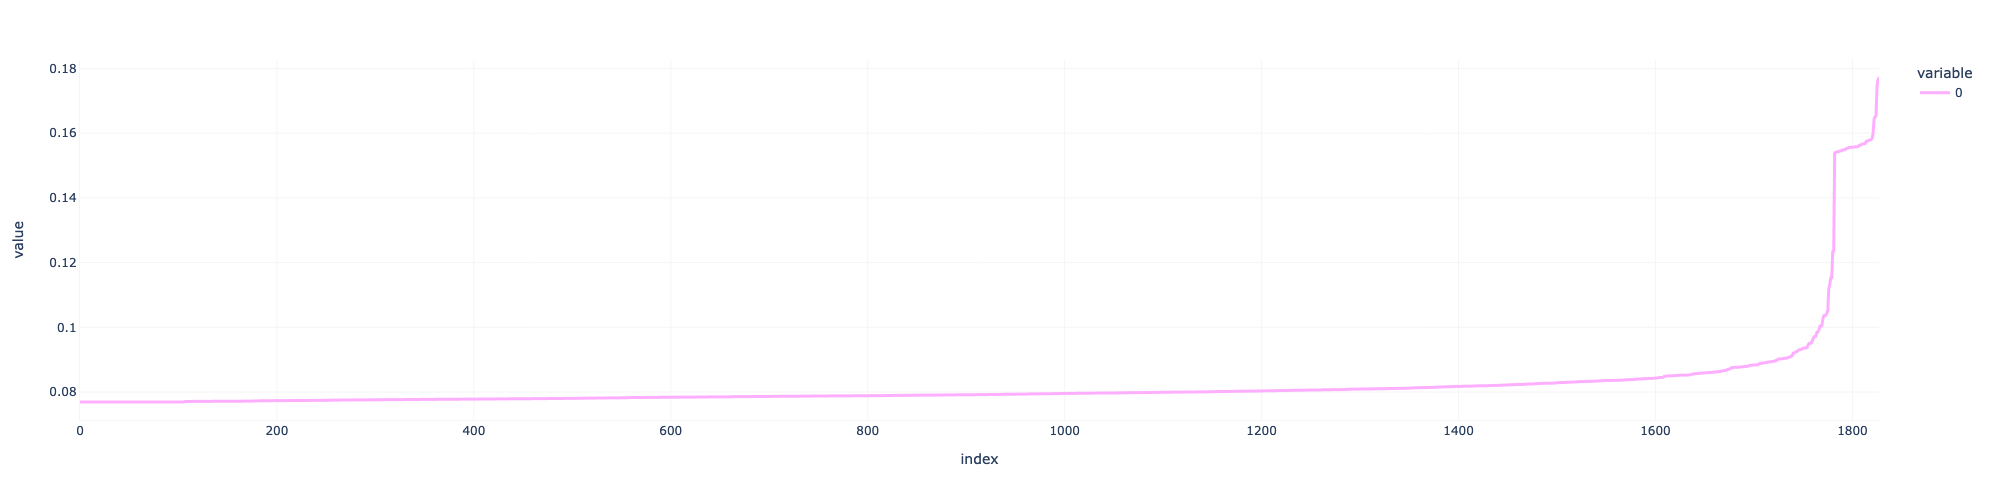

In [57]:
import plotly.express as px


#mypal2 =['#FEAEFE', '#FC05FB', '#B4FFE4', '#3FFEBA', '#1F363D', '#2B4570', '#3A2D32', '#706F6F']
fig = px.line(distances, 
              width=700, height=500
              )
#linecolor
fig.update_traces(textposition='top right', line = dict(color='#FEAEFE', width=3), marker=dict(size=8))
#axes
fig.update_xaxes(nticks=10, linecolor='#F5F5F5', gridcolor='#F5F5F5')
fig.update_yaxes(linecolor='#F5F5F5', gridcolor='#F5F5F5')
#background
fig.update_layout(plot_bgcolor='white')
#show
fig.show()

should be arround 0.09 to 1.6

In [76]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.18, #0.08
                        min_samples=14, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
#df3["dbscan_gower"] = dbscan_cluster.labels_

DBSCAN(eps=0.18, metric='precomputed', min_samples=14)

In [77]:
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances 
print(metrics.silhouette_score(distance_matrix, dbscan_cluster.labels_, metric='precomputed')) #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, dbscan_cluster.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, dbscan_cluster.labels_)) #lower ist better 
print(np.unique(dbscan_cluster.labels_, return_counts=True))

0.40121922
4605.907946388581
0.9806364076233007
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([  3, 182, 192, 195, 196, 230, 230,  71,  71, 124, 124, 105, 105]))


In [78]:
# Adding the last results to a new column in the dataframe
#df3["dbscan_gower"] = dbscan_cluster.labels_

In [79]:
df3.head()

,EBELN,EBELP,AEDAT_x,TXZ01,MATNR,EMATN,MATKL,INFNR,MENGE,MEINS,BPRME,NETPR,NETWR,LMEIN,PRDAT,GEWEI,BANFN,AEDAT_y,ERNAM,LPONR,LIFNR,EKGRP,BEDAT,kproto_labels,dbscan_gower
0,4500000000,10,2021-01-25,Nuts,R01,R01,MANUF,5300000050,41940,KG,KG,1.82,76330.8,KG,2021-01-25,KG,10000004,2021-01-25,F3,60,V01,100,2021-01-25,2,0
1,4500000000,20,2021-01-25,Blueberries,R02,R02,MANUF,5300000051,14280,KG,KG,4.00,57120.0,KG,2021-01-25,KG,10000005,2021-01-25,F3,60,V01,100,2021-01-25,1,1
2,4500000000,30,2021-01-25,Strawberries,R03,R03,MANUF,5300000052,14280,KG,KG,4.02,57405.6,KG,2021-01-25,KG,10000006,2021-01-25,F3,60,V01,100,2021-01-25,1,1
3,4500000000,40,2021-01-25,Raisins,R04,R04,MANUF,5300000053,39900,KG,KG,1.07,42693.0,KG,2021-01-25,KG,10000007,2021-01-25,F3,60,V01,100,2021-01-25,1,0
4,4500000000,50,2021-01-25,Wheat,R05,R05,MANUF,5300000054,123000,KG,KG,0.99,121770.0,KG,2021-01-25,KG,10000008,2021-01-25,F3,60,V01,100,2021-01-25,2,0


## Now we tweak Eps to non outlier

In [80]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.25, #225
                        min_samples=14, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)



DBSCAN(eps=0.25, metric='precomputed', min_samples=14)

In [81]:
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances 
print(metrics.silhouette_score(distance_matrix, dbscan_cluster.labels_, metric='precomputed')) #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, dbscan_cluster.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, dbscan_cluster.labels_)) #lower ist better 
print(np.unique(dbscan_cluster.labels_, return_counts=True))

0.34003556
10066.5096501467
0.9819346761050816
(array([0, 1, 2]), array([838, 390, 600]))


In [82]:
# Adding the last results to a new column in the dataframe
df3["dbscan_gower"] = dbscan_cluster.labels_

In [83]:
df3.sample(10)

,EBELN,EBELP,AEDAT_x,TXZ01,MATNR,EMATN,MATKL,INFNR,MENGE,MEINS,BPRME,NETPR,NETWR,LMEIN,PRDAT,GEWEI,BANFN,AEDAT_y,ERNAM,LPONR,LIFNR,EKGRP,BEDAT,kproto_labels,dbscan_gower
78,4500000019,20,2021-01-25,Large Bag (1kg),P02,P02,MANUF,5300000067,270000,ST,ST,0.12,32400.0,ST,2021-01-25,KG,10000072,2021-01-25,G3,20,V02,200,2021-01-25,0,2
926,4500000233,30,2021-01-28,Raisins,R04,R04,MANUF,5300000043,10720,KG,KG,0.77,8254.4,KG,2021-01-28,KG,10000957,2021-01-28,E2,50,V01,100,2021-01-28,1,0
616,4500000157,30,2021-01-28,Oats,R06,R06,MANUF,5300000095,75600,KG,KG,0.64,48384.0,KG,2021-01-28,nan,10000640,2021-01-28,J5,30,V01,100,2021-01-28,1,0
103,4500000025,10,2021-01-25,Small Box (500g),P03,P03,MANUF,5300000038,157000,ST,ST,0.21,32970.0,ST,2021-01-25,KG,10000097,2021-01-25,D3,20,V02,200,2021-01-25,0,2
756,4500000191,60,2021-01-28,Oats,R06,R06,MANUF,5300000095,63900,KG,KG,0.66,42174.0,KG,2021-01-28,nan,10000780,2021-01-28,J5,60,V01,100,2021-01-28,1,0
896,4500000225,30,2021-01-28,Strawberries,R03,R03,MANUF,5300000062,6400,KG,KG,5.84,37376.0,KG,2021-01-28,KG,10000927,2021-01-28,G3,60,V01,100,2021-01-28,1,1
833,4500000211,20,2021-01-28,Blueberries,R02,R02,MANUF,5300000091,22400,KG,KG,4.98,111552.0,KG,2021-01-28,nan,10000850,2021-01-28,J5,60,V01,100,2021-01-28,2,1
515,4500000132,10,2021-01-25,Large Box (1kg),P01,P01,MANUF,5300000076,166000,ST,ST,0.28,46480.0,ST,2021-01-25,KG,10000526,2021-01-25,H4,20,V02,200,2021-01-25,0,2
18,4500000004,10,2021-01-25,Nuts,R01,R01,MANUF,5300000090,32800,KG,KG,1.82,59696.0,KG,2021-01-25,nan,10000028,2021-01-25,J5,60,V01,100,2021-01-25,1,0
950,4500000239,30,2021-01-28,Strawberries,R03,R03,MANUF,5300000082,36100,KG,KG,5.94,214434.0,KG,2021-01-28,nan,10000981,2021-01-28,I3,60,V01,100,2021-01-28,2,1


In [43]:
# df3.loc[df3.dbscan_gower==-1]

##  4. Clustering with Aglomerative Clustering

In [84]:
# Clustering algorithm
from sklearn.cluster import AgglomerativeClustering

# Rand Index
from sklearn.metrics.cluster import rand_score

# Encode labels
from sklearn import preprocessing

# Confusion Matrix
from sklearn.metrics import confusion_matrix

### Single Linkage

In [85]:
K

3

In [115]:
#test 
model_single = AgglomerativeClustering(n_clusters=2, linkage='single', metric='precomputed')
clusters_single = model_single.fit_predict(distance_matrix)

In [116]:
# Adding the results to a new column in the dataframe
df3["AgloSngl_gower"] = clusters_single

In [117]:
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances
print(metrics.silhouette_score(distance_matrix, model_single.labels_, metric="precomputed")) #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, model_single.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, model_single.labels_)) #lower ist better
print(np.unique(clusters_single, return_counts=True))

0.54525983
14956.414465260852
0.3128433029171745
(array([0, 1]), array([1228,  600]))


### Average Linkage

In [89]:
model_average = AgglomerativeClustering(n_clusters=K, linkage='average', metric='precomputed')
clusters_average = model_average.fit_predict(distance_matrix)

In [90]:
clusters_average

array([1, 2, 2, ..., 0, 0, 0])

In [91]:
# Adding the results to a new column in the dataframe
df3["AgloAvg_gower"] = clusters_average

In [92]:
print(metrics.silhouette_score(distance_matrix, model_average.labels_, metric="precomputed")) #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, model_average.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, model_average.labels_)) #lower ist better 
print(np.unique(clusters_average, return_counts=True))

0.34003556
10066.5096501467
0.9819346761050817
(array([0, 1, 2]), array([600, 838, 390]))


### Complete Linkage

In [93]:
model_complete = AgglomerativeClustering(n_clusters=K, linkage='complete', metric='precomputed')
clusters_complete = model_complete.fit_predict(distance_matrix)

In [94]:
clusters_complete

array([0, 2, 2, ..., 1, 1, 1])

In [95]:
# Adding the results to a new column in the dataframe
df3["AgloComp_gower"] = clusters_complete

In [96]:
print(metrics.silhouette_score(distance_matrix, model_complete.labels_, metric="precomputed"))  #> 0.5 should be good
print(metrics.calinski_harabasz_score(distance_matrix, model_complete.labels_)) #higher ist better 
print(metrics.davies_bouldin_score(distance_matrix, model_complete.labels_)) #lower ist better
print(np.unique(clusters_complete, return_counts=True))

0.34003556
10066.5096501467
0.9819346761050817
(array([0, 1, 2]), array([838, 600, 390]))


#### Clustering-Dendrogramm for Hierarchical Clustering

In [97]:
from scipy.cluster import hierarchy

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    mypal2 =['#FEAEFE', '#FC05FB', '#B4FFE4', '#3FFEBA', '#1F363D', '#2B4570', '3A2D32', '706F6F']
    hierarchy.set_link_color_palette(['#FEAEFE', '#FC05FB', '#3FFEBA', '#2B4570'])
    dendrogram(linkage_matrix, **kwargs, above_threshold_color='#2b4570')

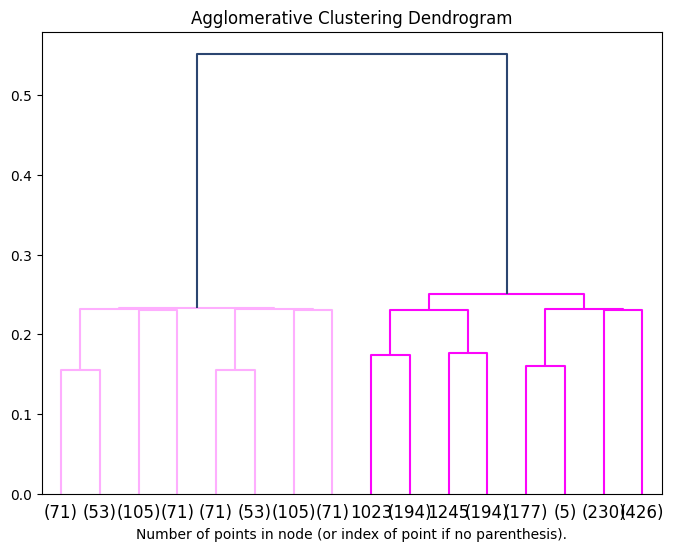

In [98]:
## linkage: single
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single', metric='precomputed')

model = model.fit(distance_matrix)
plt.figure(figsize=(8,6))
plt.title("Agglomerative Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

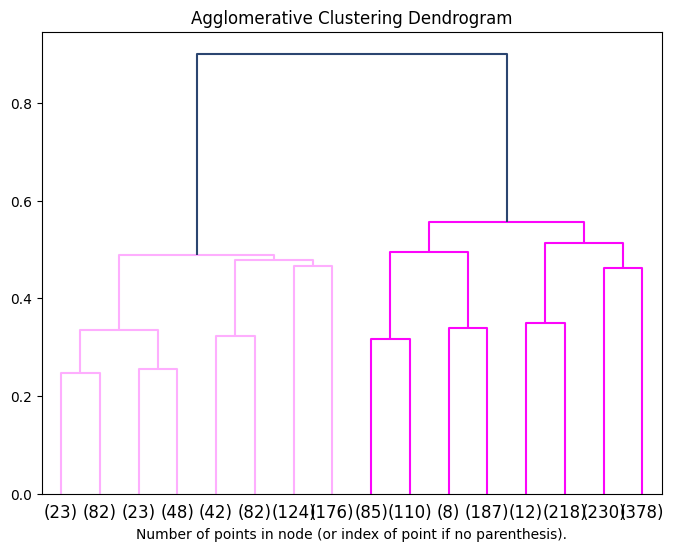

In [99]:
## linkage: complete
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete', metric='precomputed')

model = model.fit(distance_matrix)
plt.figure(figsize=(8,6))
plt.title("Agglomerative Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig("AgglomerativeClusteringDendrogram_complete.pdf")
plt.show()



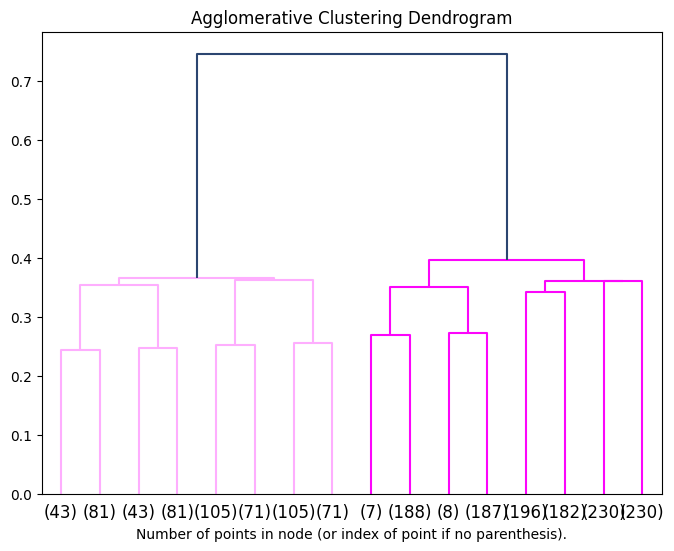

In [100]:
## linkage: average
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', metric='precomputed')

model = model.fit(distance_matrix)
plt.figure(figsize=(8,6))
plt.title("Agglomerative Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## 5. Spectral clustering

In [92]:
from sklearn.cluster import SpectralClustering


In [97]:
sc = SpectralClustering(n_clusters=K, affinity='precomputed', n_init=100, assign_labels='discretize')
spectral_complete =sc.fit_predict(distance_matrix)  
spectral_complete

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [98]:
sc = SpectralClustering(n_clusters=K, affinity='precomputed', n_init=100, assign_labels='kmeans')
spectral_complete1 =sc.fit_predict(distance_matrix)
spectral_complete1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# EXPORT

In [101]:
df3.head(5)

,EBELN,EBELP,AEDAT_x,TXZ01,MATNR,EMATN,MATKL,INFNR,MENGE,MEINS,BPRME,NETPR,NETWR,LMEIN,PRDAT,GEWEI,BANFN,AEDAT_y,ERNAM,LPONR,LIFNR,EKGRP,BEDAT,kproto_labels,dbscan_gower,AgloSngl_gower,AgloAvg_gower,AgloComp_gower
0,4500000000,10,2021-01-25,Nuts,R01,R01,MANUF,5300000050,41940,KG,KG,1.82,76330.8,KG,2021-01-25,KG,10000004,2021-01-25,F3,60,V01,100,2021-01-25,2,0,1,1,0
1,4500000000,20,2021-01-25,Blueberries,R02,R02,MANUF,5300000051,14280,KG,KG,4.00,57120.0,KG,2021-01-25,KG,10000005,2021-01-25,F3,60,V01,100,2021-01-25,1,1,2,2,2
2,4500000000,30,2021-01-25,Strawberries,R03,R03,MANUF,5300000052,14280,KG,KG,4.02,57405.6,KG,2021-01-25,KG,10000006,2021-01-25,F3,60,V01,100,2021-01-25,1,1,2,2,2
3,4500000000,40,2021-01-25,Raisins,R04,R04,MANUF,5300000053,39900,KG,KG,1.07,42693.0,KG,2021-01-25,KG,10000007,2021-01-25,F3,60,V01,100,2021-01-25,1,0,1,1,0
4,4500000000,50,2021-01-25,Wheat,R05,R05,MANUF,5300000054,123000,KG,KG,0.99,121770.0,KG,2021-01-25,KG,10000008,2021-01-25,F3,60,V01,100,2021-01-25,2,0,1,1,0


In [102]:
df3.to_feather('../Data/D3_EK_CL.ftr')